# Implementing Support Vector Machine

In this implementation, SVM algorithm is implemented to classify (i) 2D linearly separable data (ii) 2D non-linear data. 

CVXOPT package has been used to solve the convex optimization problem in dual form. 

Data Used:

I have taken the first data (dataX) from Machine Learning Course by Andrew Ng on Coursera. The second data (dataY) I have generated myself through a 2D multivariate gaussian random variable, which is further clustered into two parts using K-means algorithm.

I used following sources to refer to during implementation:

    1. Machine Learning: An Algorithmic Perpective by Stephen Marsland (Primary source)
    2. Machine Learning MOOC on Coursera by Andrew Ng/CS229 (This is also from where I have taken the data used here) 
    3. Neural Networks and Learning Machines (3rd Ed.) by Simon Haykins

In [1]:
import numpy as np 
import math 
import operator
import random
import warnings
import scipy.io
warnings.filterwarnings('ignore')

%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt                                # plotting
from scipy.stats import multivariate_normal                    # multivariate Gaussian distribution
import copy                                                    # deep copies

import cvxopt                                                  # Package for solving convex optimization problem

In [103]:
def generate_MoG_data(num_data, means, covariances, weights):
    num_clusters = len(weights)
    data = []
    for i in range(num_data):
        k = np.random.choice(len(weights), 1, p=weights)[0]
        x = np.random.multivariate_normal(means[k], covariances[k])
        data.append(x)
    return data


init_means = [
    [1, 6.2], # mean of cluster 1
    [6.2, 1], # mean of cluster 2
# mean of cluster 3
]
init_covariances = [
    [[.5, 0.1], [0.1, .5]], # covariance of cluster 1
    [[.8, .2], [.1, .5]], # covariance of cluster 2
 # covariance of cluster 3
]
init_weights = [1/2., 1/2.]  # weights of each cluster

In [104]:
mat = scipy.io.loadmat('ex6data1.mat')      # Taken from Machine Learning Course on Coursera by Andrew Ng
dataX=mat['X']
datX=np.append(dataX,mat['y'],axis=1)

In [105]:
dataY = generate_MoG_data(200, init_means, init_covariances, init_weights)   # Self generated

In [107]:
datY,c=kmeans(dataY,2,15)     #K-means procedure I have implemented else where

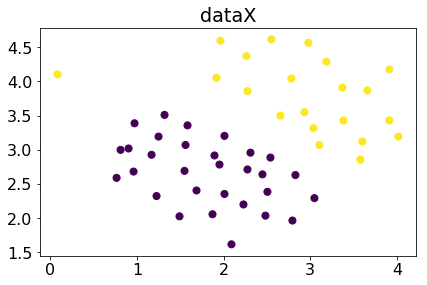

In [131]:
plt.figure()
dX = np.vstack(datX)                         
plt.scatter(dX[:,0], dX[:,1],c=dX[:,2],s=50)
plt.rcParams.update({'font.size':16})
plt.tight_layout()
plt.title('dataX')
plt.show()

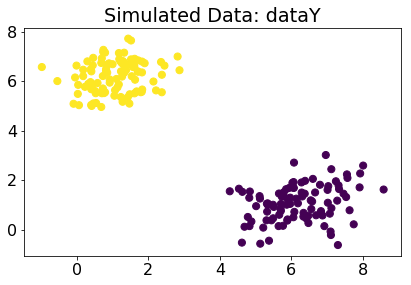

In [109]:
plt.figure()
dY = np.vstack(datY)                          # datY is the clustered version of dataX, after running K-Means Clustering
plt.scatter(dY[:,0], dY[:,1],c=dY[:,2],s=50)
plt.rcParams.update({'font.size':16})
plt.tight_layout()
plt.title('Simulated Data: dataY')
plt.show()

In [116]:
dat1=np.matrix(dX)
dat1[:,2][np.where(dat1[:,2]==0)]=-1

dat2=np.matrix(dY)
dat2[:,2][np.where(dat2[:,2]==2)]=-1

In [117]:
# For DataX

# Convex Optmization steps. Here, the matrices needed to be passed onto the QP solver are created and passed to the solver

C=0.025
K=np.dot(dat1[:,(0,1)],dat1[:,(0,1)].T)

P = np.dot(dat1[:,2],dat1[:,2].T)
q = np.matrix(-np.ones((len(dat1),1)))

G = np.concatenate((np.eye(len(dat1)),-np.eye(len(dat1))))
h = np.concatenate((C*np.ones((len(dat1),1)),np.zeros((len(dat1),1))))

A=dat1[:,2].T
b=0.0
solY = cvxopt.solvers.qp(cvxopt.matrix(P),cvxopt.matrix(q),cvxopt.matrix(G),cvxopt.matrix(h), cvxopt.matrix(A), cvxopt.matrix(b))

lambda1X=np.matrix(solY['x'])

wX=np.dot(np.multiply(lambda1,dat1[:,2]).T,dat1[:,(0,1)])

     pcost       dcost       gap    pres   dres
 0: -2.5324e+01 -2.6450e+00  2e+02  2e+01  1e-15
 1: -1.1526e+00 -2.6175e+00  3e+00  1e-01  3e-15
 2: -1.0161e+00 -1.4140e+00  4e-01  2e-16  4e-16
 3: -1.0497e+00 -1.0643e+00  1e-02  1e-16  4e-16
 4: -1.0500e+00 -1.0501e+00  1e-04  3e-17  4e-16
 5: -1.0500e+00 -1.0500e+00  1e-06  2e-16  3e-16
 6: -1.0500e+00 -1.0500e+00  1e-08  2e-16  4e-16
Optimal solution found.


In [ ]:
# Calculatng the intercept for DataX
# Here I have kept the intercept to the average over all the support vectors

sv = np.where(lambda1>1e-05)[0]
X1 = dat1[sv,0]
X1=np.append(X1,dat1[sv,1],axis=1)
lambdas1 = lambda1[sv]
targets1 = dat1[sv,2]
bX=np.sum(targets1)
bX-=np.sum(np.multiply(w[:,0],X1[:,0]))+np.sum(np.multiply(w[:,1],X1[:,1]))
bX/=len(sv)

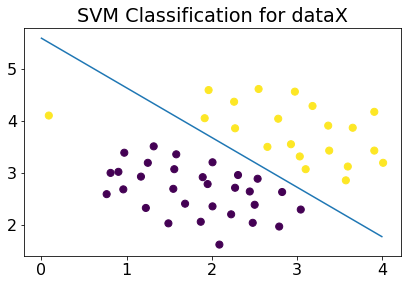

In [130]:
plt.figure()
x=range(0, 5)
y=(-wX[:,0]*x-bX)/wX[:,1]
d = np.vstack(datX)
plt.scatter(d[:,0], d[:,1],s=50,c=d[:,2])
plt.rcParams.update({'font.size':16})
plt.tight_layout()
plt.title('SVM Classification for dataX')
plt.plot(x,y.T)
plt.show()

In [125]:
# For Data Y

# Convex Optmization steps. Here, the matrices needed to be passed onto the QP solver are created and passed to the solver

C=0.025
K=np.dot(dat2[:,(0,1)],dat2[:,(0,1)].T)

P = np.dot(dat2[:,2],dat2[:,2].T)
q = np.matrix(-np.ones((len(dat2),1)))

G = np.concatenate((np.eye(len(dat2)),-np.eye(len(dat2))))
h = np.concatenate((C*np.ones((len(dat2),1)),np.zeros((len(dat2),1))))

A=dat2[:,2].T
b=0.0
solY = cvxopt.solvers.qp(cvxopt.matrix(P),cvxopt.matrix(q),cvxopt.matrix(G),cvxopt.matrix(h), cvxopt.matrix(A), cvxopt.matrix(b))

lambda1Y=np.matrix(solY['x'])

wY=np.dot(np.multiply(lambda1Y,dat2[:,2]).T,dat2[:,(0,1)])

     pcost       dcost       gap    pres   dres
 0: -1.0246e+02 -1.0050e+01  8e+02  3e+01  3e-15
 1: -4.5252e+00 -9.9508e+00  1e+01  2e-01  3e-15
 2: -4.4716e+00 -5.3329e+00  9e-01  7e-17  3e-16
 3: -4.8957e+00 -5.0084e+00  1e-01  2e-16  4e-16
 4: -4.8982e+00 -4.9028e+00  5e-03  6e-17  3e-16
 5: -4.9000e+00 -4.9000e+00  5e-05  7e-17  1e-15
 6: -4.9000e+00 -4.9000e+00  5e-07  1e-16  1e-15
Optimal solution found.


In [127]:
# Calculatng the intercept for DataY
# Here I have kept the intercept to the average over all the support vectors

sv = np.where(lambda1>1e-05)[0]
X1 = dat1[sv,0]
X1=np.append(X1,dat1[sv,1],axis=1)
lambdas1 = lambda1[sv]
targets1 = dat1[sv,2]
bY=np.sum(targets1)
bY-=np.sum(np.multiply(w[:,0],X1[:,0]))+np.sum(np.multiply(w[:,1],X1[:,1]))
bY/=len(sv)

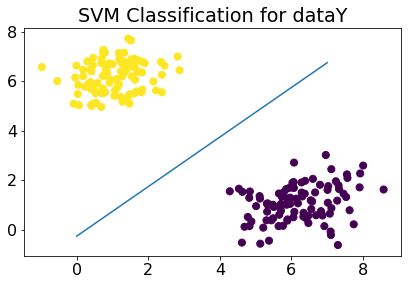

In [129]:
plt.figure()
x=range(0, 8)
y=(-wY[:,0]*x-bY)/wY[:,1]
d = np.vstack(datY)
plt.scatter(d[:,0], d[:,1],s=50,c=d[:,2])
plt.rcParams.update({'font.size':16})
plt.tight_layout()
plt.title('SVM Classification for dataY')
plt.plot(x,y.T)
plt.show()